# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to use machine learning algorithms to precict the personality type of a person given their written text in English. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from userson [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [1]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from scipy.stats import binom

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from nlp import run_models, preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Random Seed for everything
SEED = 53188535

In [ ]:
# Loading the Data (From Kaggle — https://www.kaggle.com/datasnaek/mbti-type)
cafe_df = pd.read_csv('data/mbti_1.csv')

In [ ]:
# Viewing the dataset
cafe_df

In [ ]:
# Checking the dataset size and data types
cafe_df.info()

In [ ]:
# Checking class imbalance
cafe_df['type'].value_counts(normalize=True)

In [ ]:
# Plotting class imbalance
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [ ]:
# looking at a random post for the data — Re-run cell to generate new post
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can sometimes be quite rude...

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [ ]:
# Making a copy of the DataFrame to clean and preprocess
cafe_clean = cafe_df.copy()

In [ ]:
# Lowercase y variables (MBTI types)
cafe_clean['type'] = cafe_clean.type.str.lower()

# Creating list of the targets (Useful for later iteration)
mbti_lst = list(set(cafe_clean['type'].values))
print(mbti_lst)

# Lowercase X varaible onto a new column (User Posts)
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [ ]:
# Intiating the prepreoccess class from the custom class — nlp.py
# This class provides functions to clean and tokenize our text data — view the python file for more info
prepro = preprocess()

In [ ]:
# Plotting the occurrences of data leakage where MBTI type is stated in post
plt.figure(figsize=(10,5))
for mbti in mbti_lst:
    plt.bar(str(mbti), len(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index))
    plt.title('Data Leakage \n target within predictors')
    plt.ylabel('counts')
    # print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [ ]:
# Removing the target names (MBTI type) in the actual posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.replace_mbti(x))

In [ ]:
# Cross checking to see if posts contain MBTI type
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [ ]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.pipe_remove(x))

# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.url_remove(x))

# This function will remove punctuation `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.punc_remove(x))

# Removes all characters that are not American Standard Code for Information Interchange (aka english chars)
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.remove_symbols(x))

# Fixes all spelling errors — this takes a long time to compute.
# cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.spelling(x))

In [ ]:
# This will create a column of cleaned posts that have been tokenized.
pattern = r"(?u)\b\w\w+\b" # words with 2 or more etters
tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer
cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize) # Tokenize to new column

In [ ]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_dig_token(x))

# Removing stopwords (common words with little informational value)
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_stopwords(x))

# Lemmatizing the words with POS tagging option
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.lemmend_pos(x, pos=True)) # If True, takes a while (~4mins on Apple M1)

In [ ]:
# Joining the posts tokens together into singular strings
cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.join_tokens(x)) # Creating new column

In [ ]:
# Showing what characters are in the cleaned text vs. the pre-cleaned text
clean_corpus = ' '.join(cafe_clean['joined_tokens'])
print(f'CLEANED: {"".join(sorted(set(clean_corpus.lower())))}')
print('-'*25)
print('-'*25)
print('-'*25)

corpus = ' '.join(cafe_df['posts'])
print(f'PRE-CLEANED: {"".join(sorted(set(corpus.lower())))}')

In [ ]:
# Viewing the clean DataFrame and its new columns
cafe_clean.head(5)

In [ ]:
# Visualizing the distributions of posts by length from pre-cleaned and cleaned posts

total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum() # Finding total words in pre-cleaned corupus
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum() # Finding total words in cleaned corupus
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean() # Finding average total words in pre-cleaned corupus
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean() # Finding average total words in cleaned corupus
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words') 

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()  # Finding median total words in pre-cleaned corupus
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median() # Finding median total words in cleaned corupus
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min() # Finding minimum words count in pre-cleaned corupus
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min() # Finding minimum words count in cleaned corupus
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max() # Finding maximum words count in pre-cleaned corupus
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max() # Finding maximum words count in cleaned corupus
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

# Plotting the distributions
plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
# Printing random slices of posts comparted to clean posts.
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:2000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:2000])

#### Preprocessing/Data Cleaning Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


#### Binary Classes

In [ ]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [ ]:
# Checking the Binary Target class imbalance
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

In [ ]:
# Plotting the Binary Target Class Imbalance
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

### Sentiment Analysis
Checking for insights based on post sentiment analysis

In [ ]:
# Instantiating NLTK VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
# Testing Polarity Scores
sid.polarity_scores(cafe_clean.loc[2,'joined_tokens'])

In [ ]:
# Applying Polarity Scores as a column
cafe_clean['sentiment'] = cafe_clean['joined_tokens'].apply(lambda x: sid.polarity_scores(x))

In [ ]:
# Isolating the `compound` score to its own column
cafe_clean['sentiment_total'] = cafe_clean['sentiment'].apply(lambda x: x['compound'])

In [ ]:
# Applying a binary sentiment score to a column
cafe_clean['sentiment_score'] = cafe_clean['sentiment_total'].apply(lambda x: '+' if x >= 0 else '-')

In [ ]:
# Printing and visualizing the average polarity score by MBTI type
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiment Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (polarity) Score \n using VADER');


In [ ]:
# Applying TextBlob Sentiment Polarity Score to new column for cross checking 
cafe_clean['polarity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# Applying TextBlob Subjectivity Score to new column
cafe_clean['subjectivity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
# Printing and visualizing the average polarity score by MBTI type (TextBlob)
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (polarity) Score \n using TextBlob');

In [ ]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    # print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height)
plt.ylabel('%')
plt.title('Average Sentiment (subjectivity) Score \n using TextBlob');

In [ ]:
# Plotting the distributions of polarity scores by MBTI type
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['polarity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

In [ ]:
# Plotting the distributions of subjectivity scores by MBTI type
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['subjectivity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

In [ ]:
# Plotting top tri-grams by frequency of the entire corpus — code shoutout to Susan Li (https://actsusanli.medium.com/)
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values)
plt.title('Top Corpus Trigrams by Frequency');


In [ ]:
# Plotting top bi-grams by frequency of the entire corpus — code shoutout to Susan Li (https://actsusanli.medium.com/)
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values)
plt.title('Top Corpus Trigrams by Frequency');

In [ ]:
# Plotting the frequency of words by part-of-speech
blob = TextBlob(str(cafe_clean['joined_tokens']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(15,8))
plt.barh(pos_df.index, pos_df.values);

### Takeaways:

---

Option to save clean dataframe

In [ ]:
# Uncomment below to save clean dataframe to CSV in data folder

# cafe_clean.to_csv('./data/cafe_clean.csv')

## Baseline Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [ ]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

In [ ]:
# Creating Dictionary of Baseline Classifiers for an interative model fitting approach
baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"),

                  'LogisticRegression': LogisticRegression(n_jobs=1, C=.001, max_iter=500),

                  'NaiveBayes': MultinomialNB(),
               
                  'KNN': KNeighborsClassifier(),
               
                  'RandomForest': RandomForestClassifier(max_depth=8, random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [ ]:
# Creating empty metric table to append model scoring
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
# Instantiating run_models class from nlp.py 
# This class contains the function to fit and predict the dictionary of classifiers
rm = run_models()

In [ ]:
# Fitting and predicting multiclass models using BOW vectorization
multiclass_cv = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=SEED)
multiclass_cv

In [ ]:
# Fitting and predicting multiclass models using TF-IDF vectorization
multiclass_tfidf = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=SEED)
multiclass_tfidf

In [ ]:
# Plotting the Model accuracy compared to the majority class
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1);

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
# Fitting and predicting multiclass models using BOW vectorization and Random Undersampling to balance classes
multiclass_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)
multiclass_rus_cv

In [ ]:
# Fitting and predicting multiclass models using TF-IDF vectorization and Random Undersampling to balance classes
multiclass_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)
multiclass_rus_tfidf

In [ ]:
# Plotting the Model accuracy compared to the majority class (Random UnderSampled)
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

In [ ]:
# Concatenating final metric table of multiclass modeling

multiclass_cv['other'] = 'countvec'
multiclass_tfidf['other'] = 'tfidf'
multiclass_rus_cv['other'] = 'rus_countvec'
multiclass_rus_tfidf['other'] = 'rus_tfidf'


base_mc = pd.concat([multiclass_cv, multiclass_tfidf, multiclass_rus_cv, multiclass_rus_tfidf])
base_mc

### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
bin_targets = ['i/e', 'n/s', 't/f', 'p/j']
bin_targets

In [ ]:
# Fitting and predicting binary models using BOW vectorization
bin_cv = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=SEED)
bin_cv

In [ ]:
# Fitting and predicting multiclass models using TF-IDF vectorization
bin_tfidf = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=SEED)
bin_tfidf

In [ ]:
# Plotting the Model accuracy compared to the majority class
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


#### Binary Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
# Fitting and predicting multiclass models using BOW vectorization and Random Undersampling to balance classes
bin_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=SEED)
bin_rus_cv

In [ ]:
# Fitting and predicting multiclass models using TF-IDF vectorization and Random Undersampling to balance classes
bin_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=SEED)
bin_rus_tfidf

In [ ]:
# Plotting the Model accuracy compared to the majority class (Random UnderSampled)
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .65)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .70)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .76)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .62)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


In [ ]:
# Probability we are seeing these results given a 50/50 class balance

print(f"Prob of i/e model: {1 - binom.cdf(k=(1499*2)*.65, n=1499*2, p=0.5)}")
print(f"Prob of n/s model: {1 - binom.cdf(k=(898*2)*.70, n=(898*2), p=0.5)}")
print(f"Prob of t/f model: {1 - binom.cdf(k=(1499*2)*.76, n=1499*2, p=0.5)}")
print(f"Prob of p/j model: {1 - binom.cdf(k=(2575*2)*.62, n=2575*2, p=0.5)}")

#### Binary Undersampled Model Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

## Doc2Vec
1. Multiclass
2. Thinking vs. Feeling

In [ ]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

In [ ]:
# Splitting into testing and training sets
train_df, test_df = train_test_split(cafe_clean, random_state=SEED)

In [ ]:
# Reseting index for iteration pruposes
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

#### Multiclass

In [ ]:
# Multiclass generation of train / test corpus tagged with MBTI types
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 'type'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [ ]:
# Creating the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [ ]:
# Building the vocabulary 
model.build_vocab(train_corpus)

In [ ]:
# Training the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# Showing how the model infers collections of words into vectors
vector = model.infer_vector(['unaware', 'people', 'dont', 'confidence', 'often', 'picture'])
print(vector)

In [ ]:
# Creating a function that returns targets and vectors — to be applied to each of the posts
def vector_for_learning(model, posts):
    targets, feature_vectors = zip(*[(doc.tags, model.infer_vector(doc.words)) for doc in posts])
    return targets, feature_vectors

In [ ]:
# Splitting the train and test set into targets and X vectors
# Can take a few minutes
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

In [ ]:
# Modeling with an SGD Classifier
clf = SGDClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with an Logistic Regression
logreg = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with Random Forest
rfc = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with KNN
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

#### Thinking vs. Feeling
Looking exclusively at Thinking vs. Feeling binary class because it showed the most significant icnreases in accuracy scores using BOW and TF-IDF vectorization strategies.

In [ ]:
# Binary class t/f generation of train / test corpus tagged with MBTI types
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 't/f'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [ ]:
# Creating the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [ ]:
# Building the vocabulary 
model.build_vocab(train_corpus)

In [ ]:
# Training the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# Splitting the train and test set into targets and X vectors
# Can take a few minutes
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

In [ ]:
# Modeling with an SGD Classifier
clf2 = SGDClassifier(class_weight='balanced')
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with an Logistic Regression
logreg2 = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg2.fit(X_train, y_train)
y_pred = logreg2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with Random Forest
rfc2 = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
# Modeling with KNN
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)
y_pred = knn2.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

## Model Tuning

In [ ]:
# Option to read in clean DataFrame — uncomment below

# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean = cafe_clean.dropna()

In [ ]:
# Here is where manual tuning can be done by altering the hyperparameters of teh Vectorizer and Classifier
pipe = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"))
])

In [ ]:
# Iterating through the binary classes and printing a full classification report along with confusion matrix
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(pipe, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

### Binary Modeling Takeaways:
- It seems that the T/F binary class is the only class that is able to discern itself given word usage and word choice
- The other 3 binary classes have poor F1-Scores and are often favoring their majority class. 
- For example, N/S seems high accuracy @ 86%, but when the label is truly S, the model predicts N 96% of the time

---

## Final Model

The final model choses is the binary classification of *THINKING* vs *FEEELING*

In [2]:
# Option to read in clean DataFrame — uncomment below

cafe_clean = pd.read_csv('./data/cafe_clean.csv')
cafe_clean = cafe_clean.dropna()

              precision    recall  f1-score   support

           f       0.80      0.81      0.81      1152
           t       0.78      0.78      0.78      1017

    accuracy                           0.79      2169
   macro avg       0.79      0.79      0.79      2169
weighted avg       0.79      0.79      0.79      2169



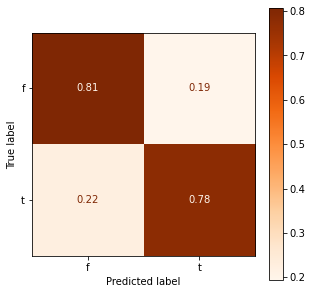

In [3]:
final_logreg = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=5)),
                ('clf', LogisticRegression(class_weight={'f': .46, 't': .54}, max_iter=1000))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_logreg.fit(X_train, y_train)

y_pred = final_logreg.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_logreg, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

              precision    recall  f1-score   support

           f       0.83      0.80      0.81      1152
           t       0.78      0.81      0.79      1017

    accuracy                           0.80      2169
   macro avg       0.80      0.80      0.80      2169
weighted avg       0.80      0.80      0.80      2169



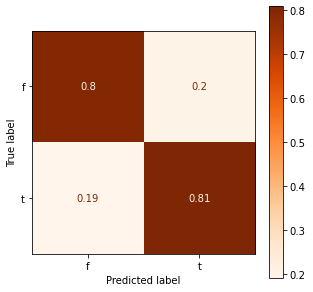

In [4]:
final_sgd = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED, loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_sgd.fit(X_train, y_train)

y_pred = final_sgd.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_sgd, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

## Further Inspect Thinking vs Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


In [7]:
cafe_clean

,Unnamed: 0,type,posts,clean_posts,post_tokens,joined_tokens,i/e,n/s,t/f,p/j,sentiment,sentiment_total,sentiment_score,polarity,subjectivity
0,0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"['moment', 'sportscenter', 'top', 'ten', 'play...",moment sportscenter top ten play pranks life c...,i,n,f,j,"{'neg': 0.134, 'neu': 0.6, 'pos': 0.266, 'comp...",0.9925,+,0.098219,0.494939
1,1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"['im', 'find', 'lack', 'post', 'alarm', 'sex',...",im find lack post alarm sex boring position of...,e,n,t,p,"{'neg': 0.136, 'neu': 0.609, 'pos': 0.255, 'co...",0.9982,+,0.087280,0.498051
2,2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","['good', 'one', 'course', 'say', 'know', 'that...",good one course say know thats bless curse abs...,i,n,t,p,"{'neg': 0.109, 'neu': 0.599, 'pos': 0.292, 'co...",0.9985,+,0.153453,0.544100
3,3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear , i enjoyed our conversation the other ...","['dear', 'enjoyed', 'conversation', 'day', 'es...",dear enjoyed conversation day esoteric gabbing...,i,n,t,j,"{'neg': 0.089, 'neu': 0.674, 'pos': 0.238, 'co...",0.9983,+,0.102580,0.536906
4,4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"['youre', 'fire', 'thats', 'another', 'silly',...",youre fire thats another silly misconception a...,e,n,t,j,"{'neg': 0.195, 'neu': 0.551, 'pos': 0.254, 'co...",0.9829,+,0.037353,0.546270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp just because i always think of cats as...,"['ixfp', 'always', 'think', 'cat', 'fi', 'doms...",ixfp always think cat fi doms reason especiall...,i,s,f,p,"{'neg': 0.176, 'neu': 0.613, 'pos': 0.211, 'co...",0.9688,+,0.107300,0.571386
8671,8671,enfp,'So...if this thread already exists someplace ...,so...if this thread already exists someplace e...,"['thread', 'already', 'exist', 'someplace', 'e...",thread already exist someplace else heck delet...,e,n,f,p,"{'neg': 0.075, 'neu': 0.6, 'pos': 0.324, 'comp...",0.9997,+,0.204584,0.562251
8672,8672,intp,'So many questions when i do these things. I ...,so many questions when i do these things. i w...,"['many', 'question', 'thing', 'would', 'take',...",many question thing would take purple pill pic...,i,n,t,p,"{'neg': 0.122, 'neu': 0.65, 'pos': 0.228, 'com...",0.9954,+,0.124294,0.512578
8673,8673,infp,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...,"['conflict', 'right', 'come', 'want', 'child',...",conflict right come want child honestly matern...,i,n,f,p,"{'neg': 0.075, 'neu': 0.651, 'pos': 0.274, 'co...",0.9995,+,0.100614,0.559802


In [5]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

In [8]:
# top_ten = list(zip(*t_fdist.most_common(15)))
# tokens = top_ten[0]
# counts = top_ten[1]

# plt.figure(figsize=(15, 8))
# plt.rcParams.update({'font.size': 18})
# plt.rc('xtick', labelsize=18) 
# plt.rc('ytick', labelsize=18) 
# plt.bar(tokens, counts)
# plt.title('Top 10 THINKING Class Word Occurences');

In [ ]:
# top_ten = list(zip(*f_fdist.most_common(10)))
# tokens = top_ten[0]
# counts = top_ten[1]

# plt.figure(figsize=(15, 8))
# plt.rcParams.update({'font.size': 18})
# plt.rc('xtick', labelsize=18) 
# plt.rc('ytick', labelsize=18) 
# plt.bar(tokens, counts)
# plt.title('Top 10 FEELING Class Word Occurences');

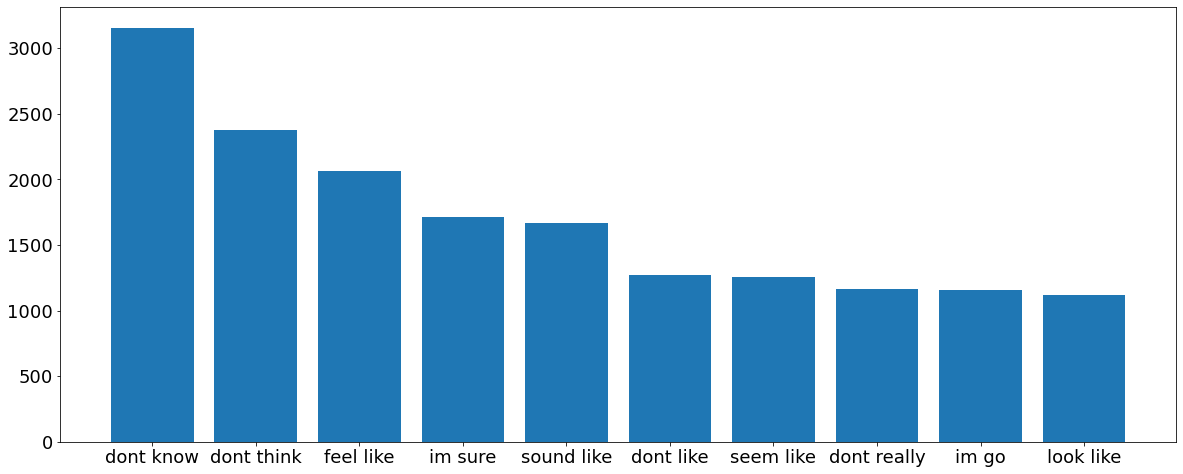

In [9]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

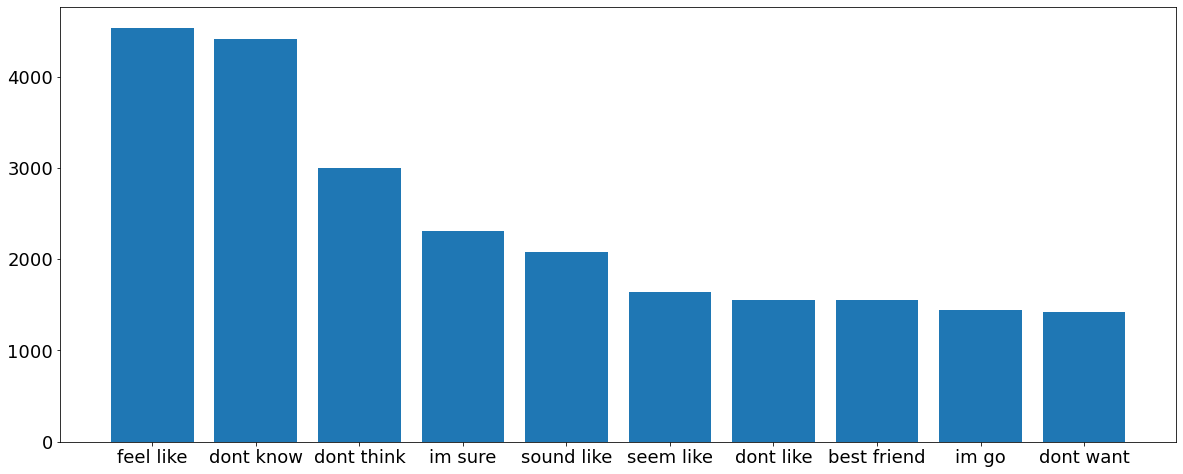

In [10]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

In [12]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

print(final_sgd.predict([f_test_sample])[0], '--', f"{round(max(final_sgd.predict_proba([f_test_sample])[0])*100, 2)}%")


f -- 62.02%


In [13]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

print(final_sgd.predict([t_test_sample])[0], '--', f"{round(max(final_sgd.predict_proba([t_test_sample])[0])*100, 2)}%")


t -- 76.35%


In [ ]:
# Uncomment below to save final model
# pickle.dump(final_sgd, open('./models/final_model.pkl', 'wb'))

### Highest TFIDF

In [14]:
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

In [15]:
X_train_t = train_set[train_set['t/f'] == 't']['joined_tokens']
X_train_f = train_set[train_set['t/f'] == 'f']['joined_tokens']

In [16]:
tfidf_t = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_t = tfidf_t.fit_transform(X_train_t)
feature_array_t = np.array(tfidf_t.get_feature_names())

In [17]:
tfidf_f = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_f = tfidf_f.fit_transform(X_train_f)
feature_array_f = np.array(tfidf_f.get_feature_names())

In [18]:
tfidf_df_t = pd.DataFrame(train_tfidf_t.toarray(), columns=tfidf_t.get_feature_names())
tfidf_df_f = pd.DataFrame(train_tfidf_f.toarray(), columns=tfidf_f.get_feature_names())

In [19]:
highest_tfidf_t = []
for column in tfidf_df_t.columns:
    highest_tfidf_t.append((column, tfidf_df_t[column].max()))

In [20]:
highest_tfidf_f = []
for column in tfidf_df_f.columns:
    highest_tfidf_f.append((column, tfidf_df_f[column].max()))

In [21]:
def getKey(item):
    return item[1]

high_tfidf_t = sorted(highest_tfidf_t, key=getKey, reverse=True)
high_tfidf_f = sorted(highest_tfidf_f, key=getKey, reverse=True)

In [24]:
high_tfidf_f[:10]

[('type likely', 0.8313310793219044),
 ('congrats', 0.8106021712197423),
 ('sir', 0.7703091773379824),
 ('grateful', 0.7597962125368377),
 ('flight', 0.7512881387570077),
 ('ugly', 0.7203540103400556),
 ('temperament', 0.7196939286650329),
 ('welcome', 0.7144088293416635),
 ('hug', 0.7054509085115117),
 ('welcome perc', 0.7047464575898609)]

In [25]:
high_tfidf_t[:10]

[('youtube', 0.8409272452680038),
 ('go go', 0.8283567614272469),
 ('type likely', 0.8012866431672608),
 ('ha', 0.7977459627582976),
 ('blush', 0.773445485643529),
 ('welcome forum', 0.7608722391535365),
 ('metal', 0.7422110586386929),
 ('kitteh', 0.7225445257558895),
 ('cool', 0.7214607333682072),
 ('ban', 0.6912907344379339)]

#### Creating testing sample and TF-IDF Vectorizer for the personality_predictor.py APP

In [26]:
testing_df = cafe_clean.iloc[y_test.index]

In [27]:
testing_set = pd.concat([y_test, X_test], axis=1)

In [28]:
t_sample = testing_df[testing_df['t/f'] == 't'].sample(50, replace=False, random_state=SEED)
f_sample = testing_df[testing_df['t/f'] == 'f'].sample(50, replace=False, random_state=SEED)

testingsample_set = pd.concat([t_sample, f_sample], axis=0)

In [ ]:
# Uncomment to save testing sample df to data folder
# testingsample_set.to_csv('./data/testingsample_df.csv')

In [29]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [30]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=50)

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

tfidf.fit_transform(X_train, y_train)

<6505x10848 sparse matrix of type '<class 'numpy.float64'>'
	with 2916525 stored elements in Compressed Sparse Row format>

In [31]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [32]:
rint = np.random.randint(0, len(X_test))
feature_array = np.array(tfidf.get_feature_names())
response = tfidf.transform([X_test[rint]])
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
print(y_test[rint])
print(top_n)
print('-'*25)
print(X_test[rint])

f
['im' 'people' 'aw' 'hand' 'im right']
-------------------------
im glad ive lose friend time ive go personal problem havent feel outgo horrible definitely agree find people get along easily sorta easily communicate people hold pleasant conversation im bit shy think come across slightly socially awkward constantly state daydream often people ask im even listen theyre say mid conversation try concentrate sometimes hello everyone looooong time away site return another vent type post yay im entirely sure thing weird big daily struggle communicate human being without say something stupid ramble stuff nobody care hour feel different welcome fellow wave im hi im favourite lyric moment domino destitute coheed cambria courage stop turn would worst everybodys panic stand look like ive date saw never take test come across one get along best stable describe story life damn im bad socialise feel like everybody think im weird im stuff never seem able capricorn year dog do proud im one people woma

In [ ]:
# Uncomment to save testing sample df to data folder

# pickle.dump(tfidf, open('./models/final_tfidf.pkl', 'wb'))

---
## Random Sample Reddit

### Testing of unseen data from Reddit

In [ ]:
reddit_sample = pd.read_csv('./data/reddit_sample.csv')
reddit_sample

In [ ]:
reddit_sample[reddit_sample['joined_tokens'].isna() == True]

In [ ]:
reddit_X = reddit_sample['joined_tokens']
reddit_y = reddit_sample['t/f']

y_pred = final_sgd.predict(reddit_X)
acc_score = accuracy_score(reddit_y, y_pred)

print(classification_report(y_pred=y_pred, y_true=reddit_y, target_names=reddit_sample['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_sgd, reddit_X, reddit_y, ax=ax, normalize='true')
plt.grid(False);

---

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps